## Import requried libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import datetime
from math import sqrt

from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(1460, 81)

In [4]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Cleaning

In [5]:
df.drop(columns=['Id'], axis=0, inplace=True)

In [6]:
null_cols = round(100*(df.isnull().sum()/len(df.index)), 2)
null_cols[ null_cols > 80 ]

Alley          93.77
PoolQC         99.52
Fence          80.75
MiscFeature    96.30
dtype: float64

In [7]:
df.drop(null_cols[ null_cols > 80 ].index, axis=1, inplace=True)
df.shape

(1460, 76)

In [8]:
df.duplicated().value_counts()

False    1460
dtype: int64

In [9]:
dtypes = set(df.dtypes.to_list())
dtypes

{dtype('int64'), dtype('float64'), dtype('O')}

In [10]:
cat_cols = []
num_cols = []

for col in df.columns:
    if df[col].dtype == "object":
        cat_cols.append(col)
    else:
        num_cols.append(col)
print(f"Numerical Columns: {len(num_cols)}")
print(f"Categorical Columns: {len(cat_cols)}")

Numerical Columns: 37
Categorical Columns: 39


In [11]:
df[cat_cols].nunique().sort_values().head(15)

Street          2
CentralAir      2
Utilities       2
GarageFinish    3
LandSlope       3
PavedDrive      3
BsmtQual        4
ExterQual       4
MasVnrType      4
KitchenQual     4
BsmtCond        4
BsmtExposure    4
LandContour     4
LotShape        4
HeatingQC       5
dtype: int64

In [12]:
df.isna().sum()[df.isna().sum() !=0].sort_values(ascending=False)

FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
BsmtExposure     38
BsmtFinType2     38
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
MasVnrType        8
MasVnrArea        8
Electrical        1
dtype: int64

In [13]:
df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFireplace')

In [14]:
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df[garage_cols] = df[garage_cols].fillna('NoGarage')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [15]:
bsmt_cols = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtFinType1', 'BsmtCond']
df[bsmt_cols] = df[bsmt_cols].fillna('NoBasement')

In [16]:
df.isna().sum()[df.isna().sum() !=0].sort_values(ascending=False)

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

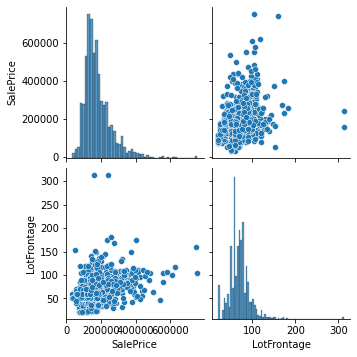

In [17]:
sns.pairplot(df[['SalePrice','LotFrontage']])
plt.show()

In [18]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

In [19]:
df.dropna(inplace = True)
df.isna().sum()[df.isna().sum() !=0]

Series([], dtype: int64)

## Exploratory Data Analysis

<AxesSubplot:>

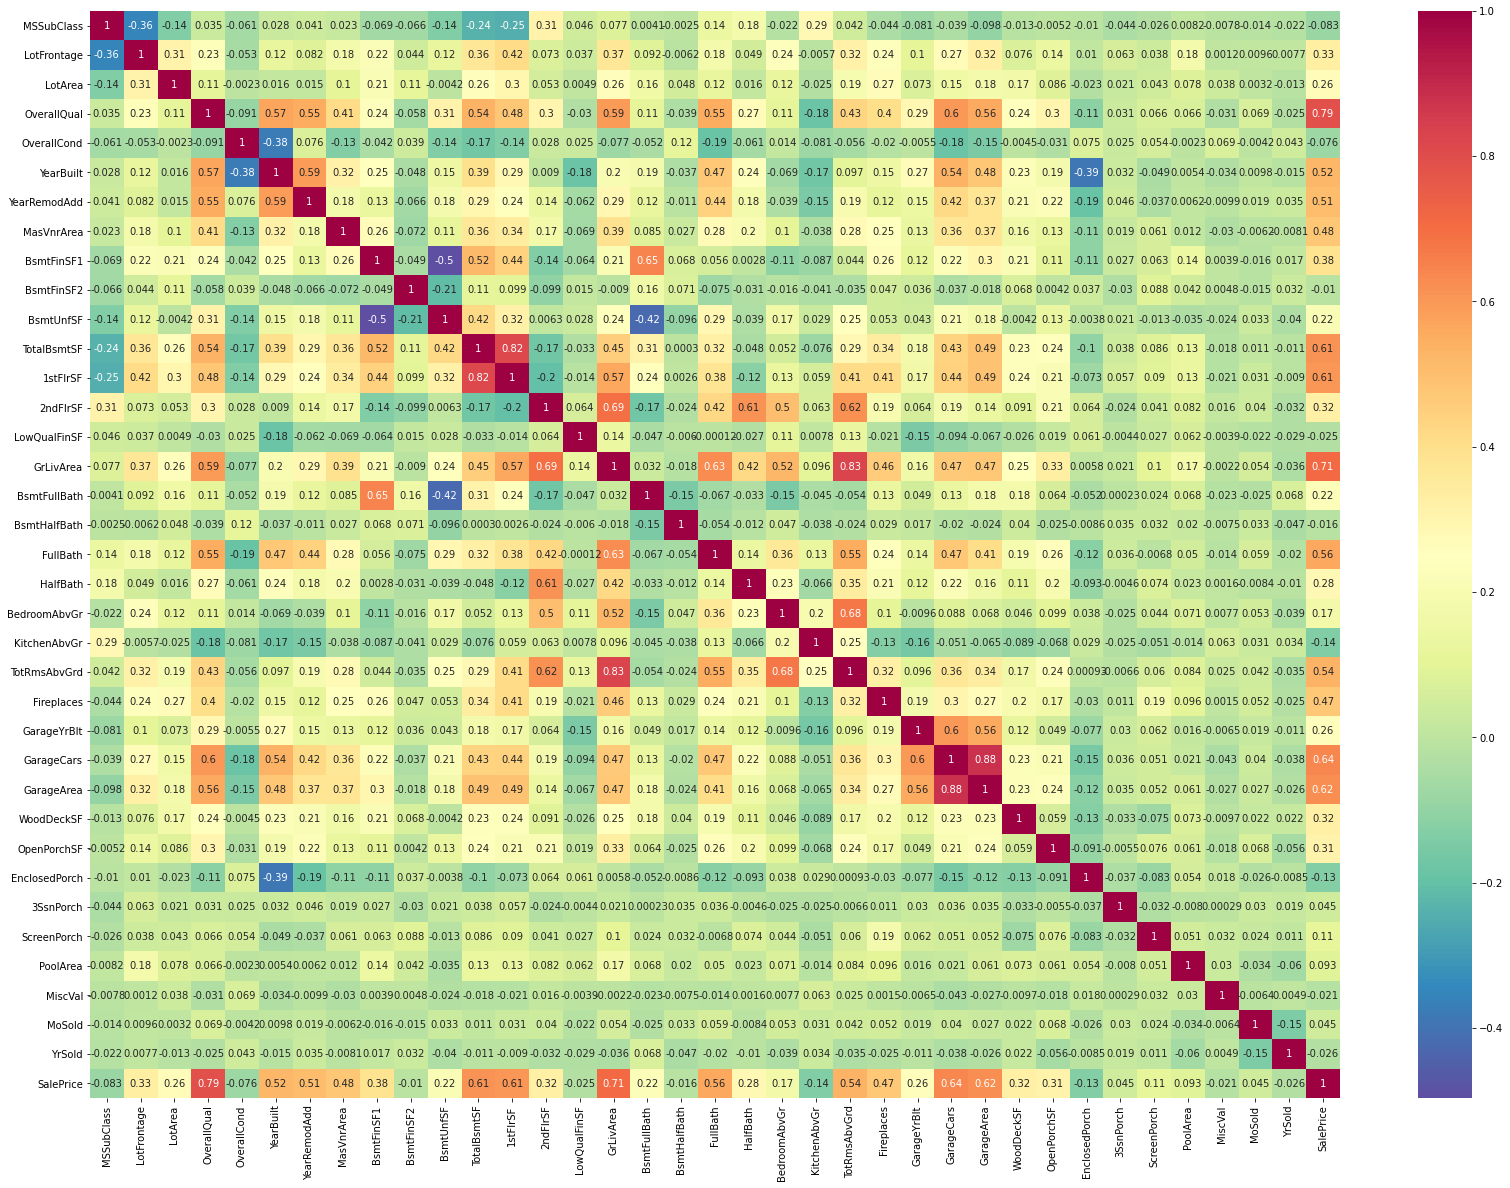

In [20]:
plt.figure(figsize=(28, 20))
sns.heatmap(df.corr(), annot = True, cmap='Spectral_r')

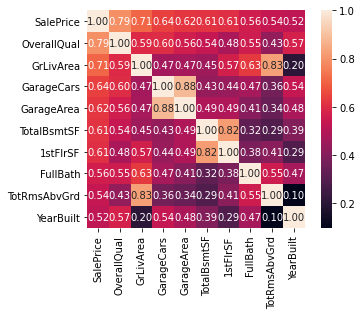

In [21]:
#Identifying highly correlated varaibles
corr_matrix = df.corr()
top_10_cols = corr_matrix.nlargest(10,'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[top_10_cols].values.T)
sns.heatmap(cm, square=True, cbar=True, fmt='.2f',annot=True, annot_kws={'size': 10}, yticklabels=top_10_cols.values, xticklabels=top_10_cols.values)
plt.show()

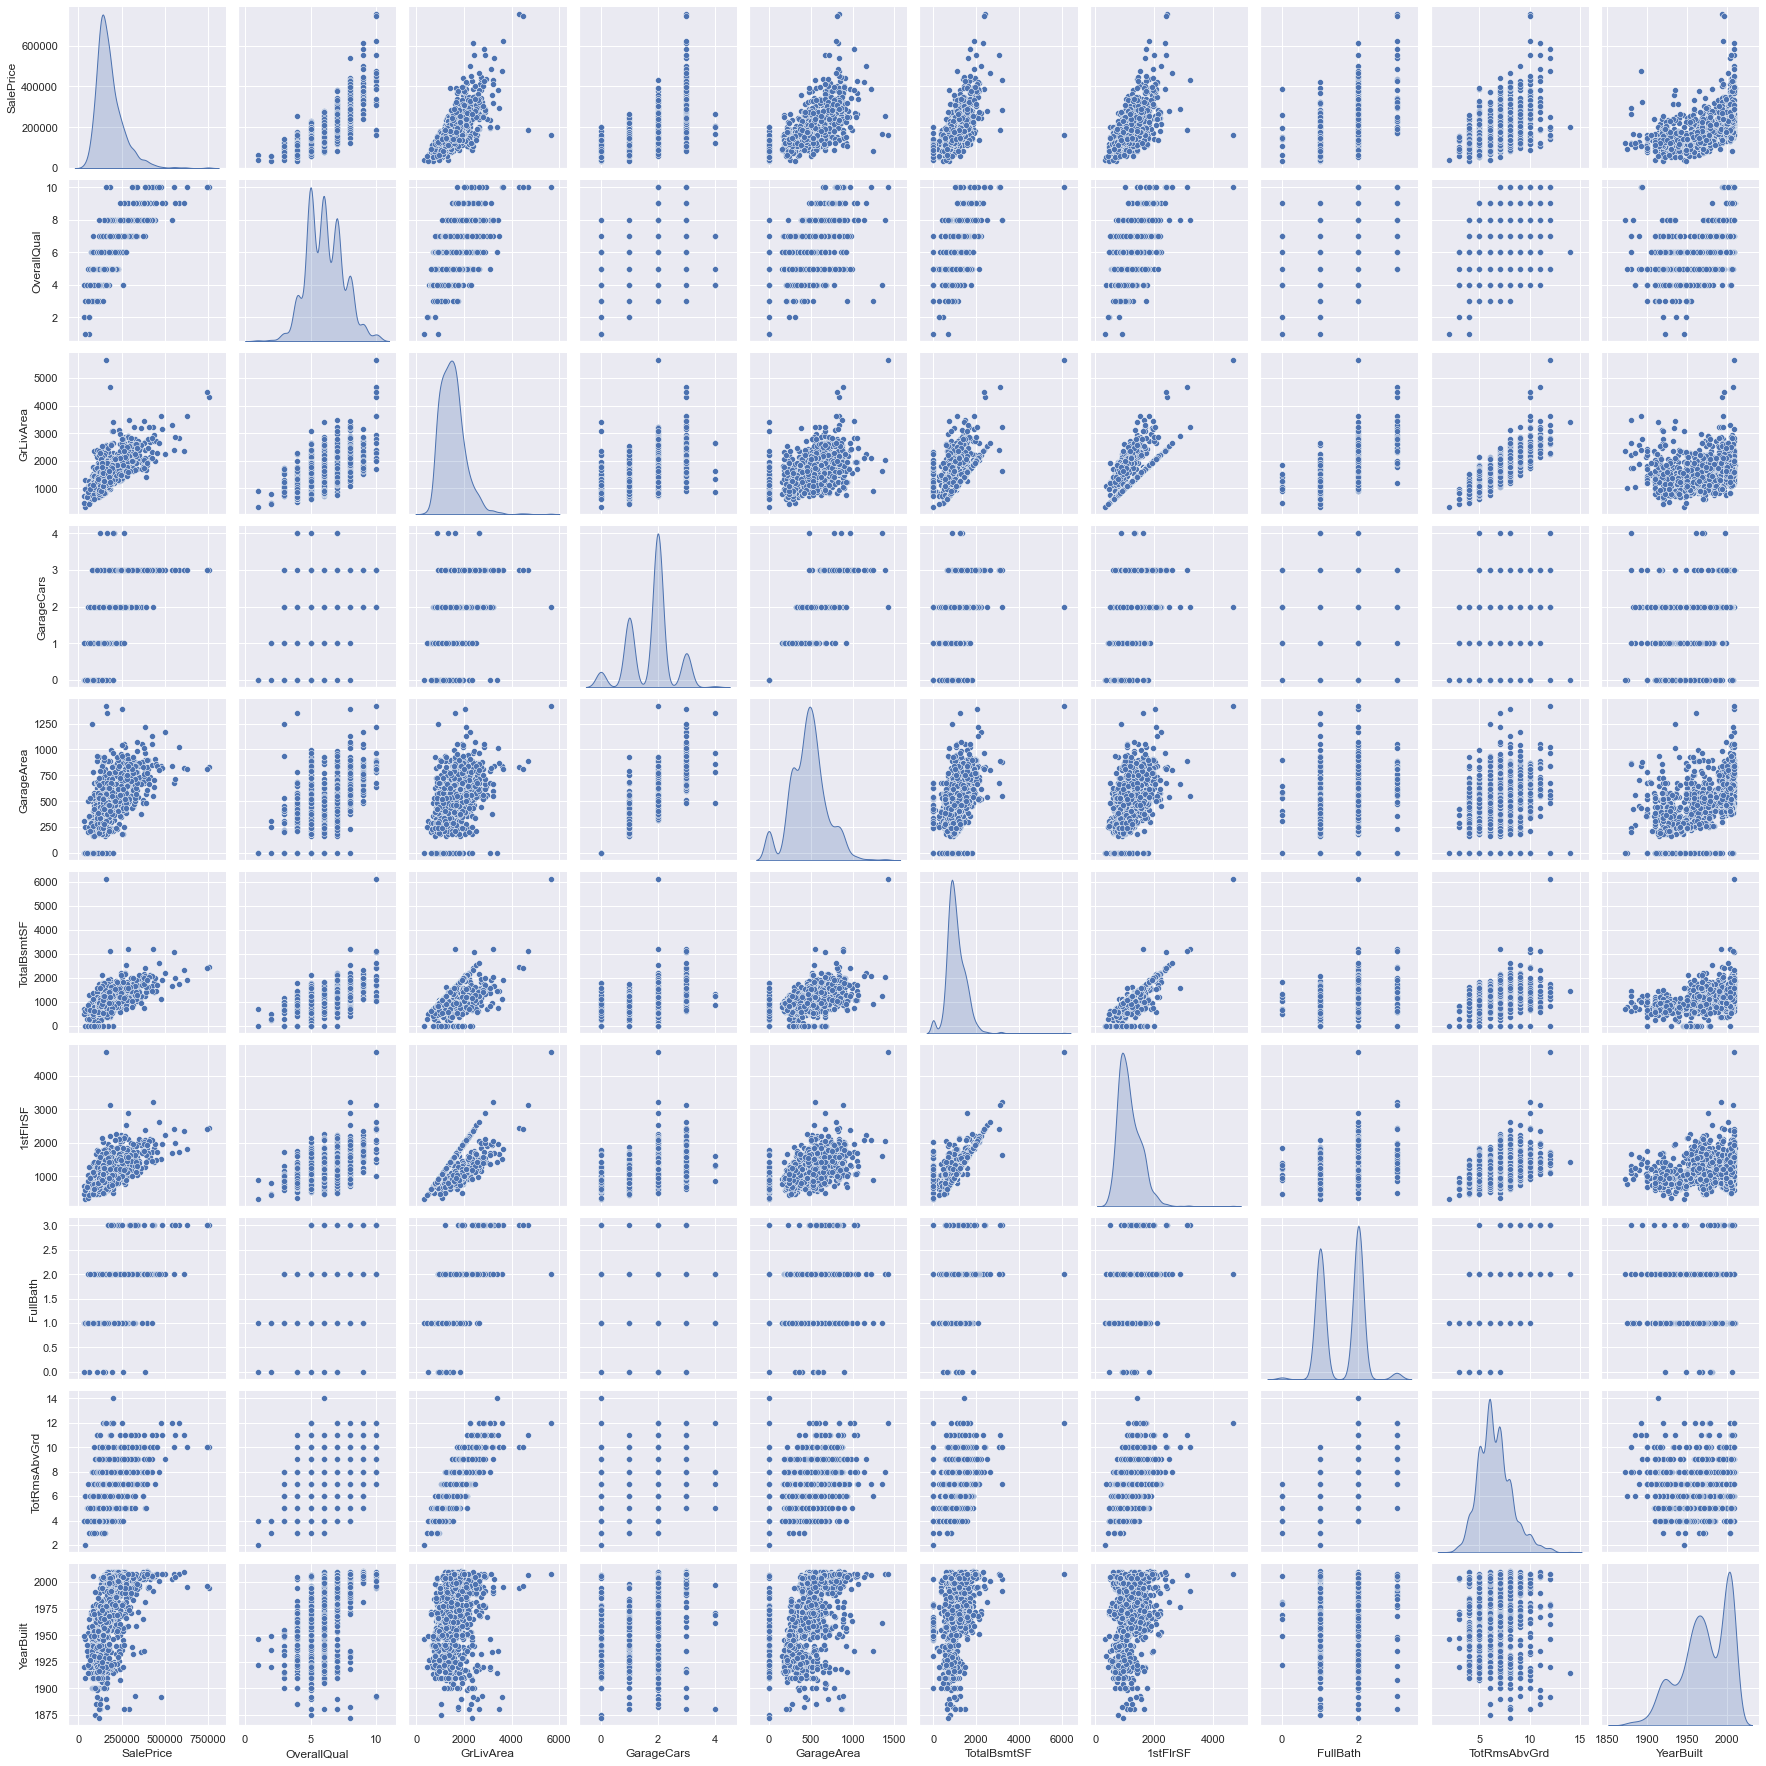

In [22]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'YearBuilt']
sns.pairplot(df[top_10_cols], diag_kind='kde')
plt.show()

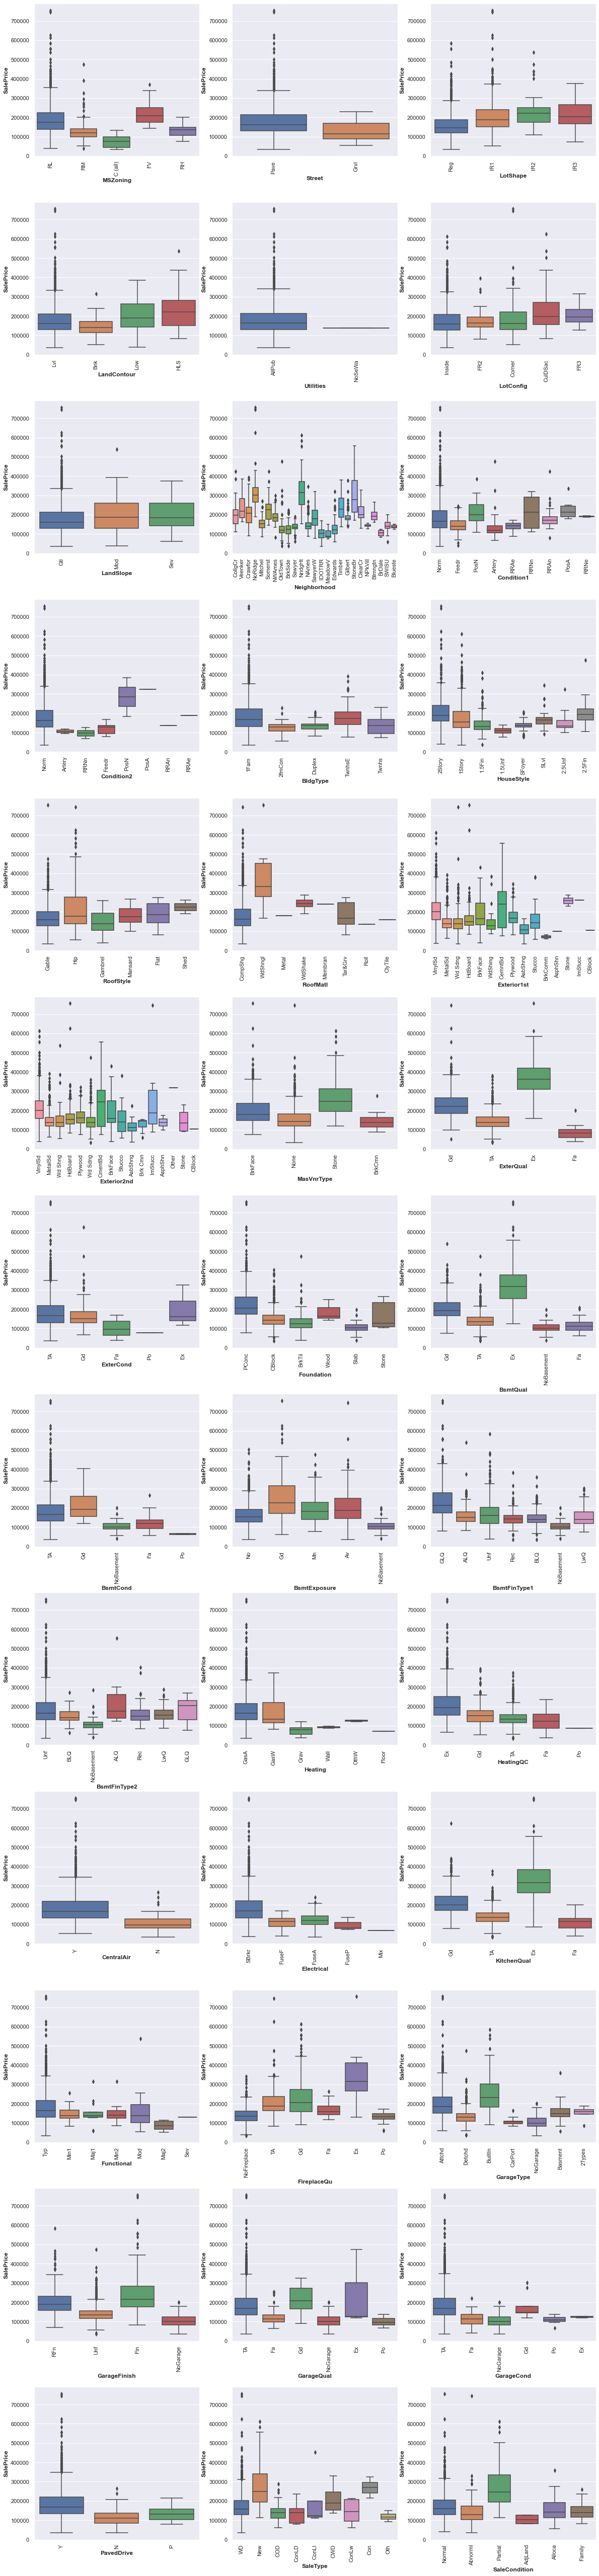

In [23]:
plt.figure(figsize=(20,100))
for i in range(0, len(cat_cols)):
    plt.subplot(14, 3, i+1)
    ax = sns.boxplot(x=cat_cols[i], y='SalePrice', data=df)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
    ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
plt.subplots_adjust(hspace=0.3)
plt.show()

### Univariate and Bivariate Analysis on top 10 features

In [25]:
# plt.figure(figsize=(14,6))
# plt.subplot(1, 2, 1)
# sns.countplot(df["OverallQual"])
# plt.subplot(1, 2, 2)
# sns.boxplot(x="OverallQual",y="SalePrice",data=df)

In [26]:
# f,axes=plt.subplots(1,2,figsize=(14,6))
# sns.distplot(df["GrLivArea"],bins=20, ax=axes[0])
# sns.jointplot(x=df["GrLivArea"],y=df["SalePrice"], ax=axes[1])
# axes[1].set_axis_off()
# plt.show()

In [27]:
# plt.figure(figsize=(14,6))
# plt.subplot(1, 2, 1)
# sns.boxplot(df["GarageCars"])
# plt.subplot(1, 2, 2)
# sns.boxplot(x="GarageCars",y="SalePrice",data=df)

In [28]:
# f,axes=plt.subplots(1,2,figsize=(14,6))
# sns.distplot(df["TotalBsmtSF"],bins=20, ax=axes[0])
# sns.jointplot(x="TotalBsmtSF",y="SalePrice",data=df, ax=axes[1])
# axes[1].set_axis_off()
# plt.show()

In [29]:
# plt.figure(figsize=(14,6))
# plt.subplot(1, 2, 1)
# sns.countplot(df["FullBath"])
# plt.subplot(1, 2, 2)
# sns.boxplot(x="FullBath",y="SalePrice",data=df)

In [30]:
# plt.figure(figsize=(20,14))
# plt.subplot(2, 1, 1)
# ax = sns.countplot(df["YearBuilt"])
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
# plt.subplot(2, 1, 2)
# ax1 = sns.boxplot(x="YearBuilt",y="SalePrice",data=df)
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
# plt.tight_layout()
# plt.show()

### Deriving additional features

In [31]:
df['CurrentYear'] = datetime.datetime.now().year
df["Age"] = df['CurrentYear'] - df['YearBuilt']
df.drop(['CurrentYear', 'YearBuilt'], axis = 1, inplace = True)

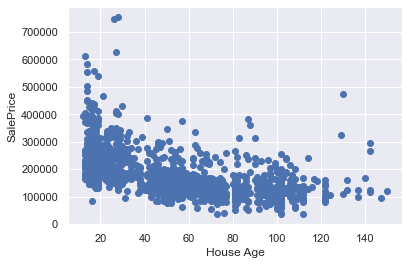

In [32]:
plt.scatter(x=df['Age'], y=df['SalePrice'])
plt.xlabel("House Age"); plt.ylabel("SalePrice");

In [33]:
cat_cols = []
num_cols = []

for col in df.columns:
    if df[col].dtype == "object":
        cat_cols.append(col)
    else:
        num_cols.append(col)
print(f"Numerical Columns: {len(num_cols)}")
print(f"Categorical Columns: {len(cat_cols)}")
print(cat_cols)

Numerical Columns: 37
Categorical Columns: 39
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


### Creating Dummy variables for categorical columns

In [34]:
for col in cat_cols:
    dummy_df = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df,dummy_df],axis = 1)
    df = df.drop(columns=[col])

In [35]:
df.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,196.0,706,0,150,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,0.0,978,0,284,...,0,0,0,0,1,0,0,0,1,0


### Train-Test Split

In [36]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (1015, 246)
X_test Shape: (436, 246)
y_train Shape: (1015,)
y_test Shape: (436,)


### Feature Scaling

In [39]:
scaler = StandardScaler()

In [40]:
features_to_scale = num_cols.copy()
features_to_scale.remove('SalePrice')
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_train.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
801,-0.650652,-1.306726,-0.513865,-1.552452,1.293141,0.238209,-0.562965,-0.502945,-0.297804,0.936307,...,0,0,0,0,1,0,0,0,1,0
569,0.788676,-0.004274,-0.315476,-0.824292,-0.538734,-0.301373,-0.562965,1.097605,-0.297804,-1.320626,...,0,0,0,0,1,0,0,0,1,0


In [41]:
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
X_test.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
357,1.50834,-1.133355,-0.565062,-0.824292,-0.538734,-0.448532,-0.562965,0.949564,-0.297804,-0.715162,...,0,0,0,0,1,0,0,0,1,0
824,-0.89054,0.470333,0.056414,1.360189,-0.538734,1.023055,-0.562965,-0.925611,-0.297804,2.043312,...,0,0,1,0,0,0,0,0,0,1


## Model Building

In [46]:
x_train_sm = sm.add_constant(X_train)
x_test_sm = sm.add_constant(X_test,  has_constant='add')

In [49]:
lr_model = sm.OLS(y_train, x_train_sm, family = sm.families.Binomial())
res = lr_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     60.21
Date:                Wed, 05 Oct 2022   Prob (F-statistic):               0.00
Time:                        07:48:39   Log-Likelihood:                -11401.
No. Observations:                1015   AIC:                         2.327e+04
Df Residuals:                     783   BIC:                         2.441e+04
Df Model:                         231                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -5.766e+05   5.33e+04    -10.820      0.000   -6.81e+05   -4.72e+05
MSSubClass                437.4479   3911.343      0.112      0.911   -7240.512    8115.408
LotFrontage              2509.9132   1127.574      2.226      0.026     296.487    4723.339
LotArea                  9477.5462   1355.964      6.990      0.000    6815.791    1.21e+04
OverallQual              9802.0960   1577.242      6.215      0.000    6705.972    1.29e+04
OverallCond              5927.9942   1091.101      5.433      0.000    3786.164    8069.824
YearRemodAdd             1938.5973   1327.620      1.460      0.145    -667.518    4544.713
MasVnrArea               3486.4751   1152.417      3.025      0.003    1224.282    5748.668
BsmtFinSF1               1.028e+04   1250.863      8.218      0.000    7824.291    1.27e+04
BsmtFinSF2                818.2387   1466.469      0.558      0.577   -2060.438    3696.915
BsmtUnfSF                 542.0588   1070.955      0.506      0.613   -1560.225    2644.342
TotalBsmtSF               1.16e+04   1801.232      6.439      0.000    8061.769    1.51e+04
1stFlrSF                 7313.2595   1989.665      3.676      0.000    3407.551    1.12e+04
2ndFlrSF                 1.888e+04   2023.286      9.330      0.000    1.49e+04    2.28e+04
LowQualFinSF            -2004.4138   1025.482     -1.955      0.051   -4017.433       8.605
GrLivArea                2.053e+04   1544.777     13.292      0.000    1.75e+04    2.36e+04
BsmtFullBath              494.1138   1165.003      0.424      0.672   -1792.785    2781.012
BsmtHalfBath            -1445.6947    853.031     -1.695      0.091   -3120.193     228.804
FullBath                   88.0883   1396.526      0.063      0.950   -2653.290    2829.466
HalfBath                   86.9787   1249.046      0.070      0.945   -2364.896    2538.853
BedroomAbvGr            -3428.7465   1290.697     -2.657      0.008   -5962.382    -895.111
KitchenAbvGr            -3753.8021   1510.758     -2.485      0.013   -6719.417    -788.188
TotRmsAbvGrd            -1248.7439   1817.830     -0.687      0.492   -4817.140    2319.653
Fireplaces               1964.5135   1934.659      1.015      0.310   -1833.218    5762.245
GarageYrBlt              6.279e+04   3.32e+04      1.892      0.059   -2355.588    1.28e+05
GarageCars               5846.1721   1991.624      2.935      0.003    1936.617    9755.727
GarageArea              -1040.9305   1943.473     -0.536      0.592   -4855.964    2774.103
WoodDeckSF               1292.2244    833.905      1.550      0.122    -344.730    2929.179
OpenPorchSF               -17.6447    884.128     -0.020      0.984   -1753.187    1717.898
EnclosedPorch            -107.0311    878.023     -0.122      0.903   -1830.590    1616.528
3SsnPorch                 916.6823    753.796  

### Prediction and Evaluation

In [50]:
y_train_pred = res.predict(x_train_sm)
y_test_pred = res.predict(x_test_sm)

Text(0.5, 0, 'Errors')

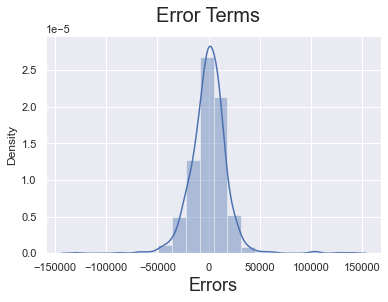

In [51]:
#calculating residuals
residual = y_train - y_train_pred

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)            
plt.xlabel('Errors', fontsize = 18)    

Observations:
    
- R2 score is good.
- The error terms are normally distributed

Text(0, 0.5, 'y_pred')

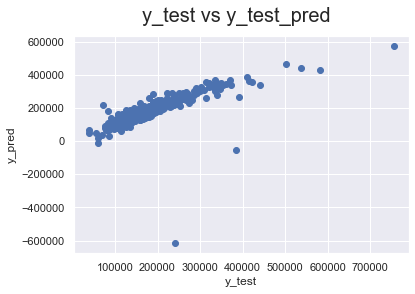

In [54]:
# Plotting y_test and y_test_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)           
plt.xlabel('y_test')                          
plt.ylabel('y_pred')

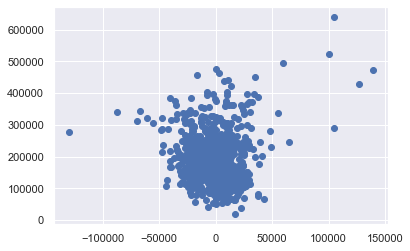

In [55]:
#Checking non-linearity in data by plotting residuals vs predictors
plt.scatter(y_train - y_train_pred, y_train_pred)

Observations

- Residuals are not normally scattered
- No extreme points are found
- The Spread of residuals does not remain constant

In [62]:
def metrics(y_true, y_pred, prefix=''):
    metrics = {}
    #R2 score
    metrics[f'{prefix} R2'] = r2_score(y_true, y_pred)
    #RSS
    metrics[f'{prefix} RSS'] = np.sum(np.square(y_true - y_pred))
    #MSE
    metrics[f'{prefix} MSE'] = mean_squared_error(y_true, y_pred)
    #RMSE
    metrics[f'{prefix} RMSE'] = sqrt(mean_squared_error(y_true, y_pred))
    return metrics

In [63]:
metrics(y_train, y_train_pred, 'Train')

{'Train R2': 0.9467022299409539,
 'Train RSS': 338867445461.4565,
 'Train MSE': 333859552.17877483,
 'Train RMSE': 18271.823997039126}

In [64]:
metrics(y_test, y_test_pred, 'Test')

{'Test R2': 0.5422678556292164,
 'Test RSS': 1263684725742.6082,
 'Test MSE': 2898359462.7124043,
 'Test RMSE': 53836.413910218835}